In [210]:
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from collections import defaultdict

In [211]:
dataset_name = '../recomb_ssc.hg38_upd'
ped_file = '../../DATA/ssc.hg38/ssc.ped'

#dataset_name = '../recomb_ihart.ms2_upd'
#ped_file = '../../DATA/ihart.ms2/ihart.ped.quads.ped'

In [212]:
# pull affected status
# (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 6:
            fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
            if 'ssc' in ped_file:
                child_id = child_id.replace('.', '_')
            child_id_to_affected[child_id] = disease_status
            child_id_to_sex[child_id] = sex


print('ped loaded')
print('children', len(child_id_to_affected))


ped loaded
children 9371


In [213]:
with open('%s/upds.json' % dataset_name, 'r') as f:
    #upds = [x for x in json.load(f) if x['chrom'] != 'X']
    upds = json.load(f)

In [214]:
with open('%s/deletions.json' % dataset_name, 'r') as f:
    #deletions = [x for x in json.load(f) if x['chrom'] != 'X']
    deletions = json.load(f)

In [215]:
with open('%s/sibpairs.json' % dataset_name, 'r') as f:
    sibpairs = json.load(f)
    
child_to_sib = dict()
for sibpair in sibpairs:
    child_to_sib[(sibpair['family'], sibpair['sibling1'])] = sibpair['sibling2']
    child_to_sib[(sibpair['family'], sibpair['sibling2'])] = sibpair['sibling1']

In [216]:
print(len([d for d in deletions if d['chrom']=='X']))

37823


In [217]:
# interval, het_upd/iso_upd/del, mat/pat, nt/aut
all_counts = []
all_positions = []
all_chroms = []
for i, chrom in enumerate([str(x) for x in range(1, 23)]):
    print(chrom)
    chrom_upds = [x for x in upds if x['chrom']==chrom]
    chrom_dels = [x for x in deletions if x['chrom']==chrom]

    positions = set()
    for upd in chrom_upds:
        positions.add(upd['start_pos'])
        positions.add(upd['start_pos']-1)
        positions.add(upd['end_pos'])
        positions.add(upd['end_pos']-1)

    for d in chrom_dels:
        positions.add(d['start_pos'])
        positions.add(d['start_pos']-1)
        positions.add(d['end_pos'])
        positions.add(d['end_pos']-1)

    positions = np.array(sorted(positions))
    pos_to_index = dict([(x, i) for i, x in enumerate(positions)])

    # interval, het_upd/iso_upd/del, mat/pat, nt/aut, MM/FM/MF/FF
    counts = np.zeros((len(positions), 3, 2, 2, 4))

    for upd in chrom_upds:
        counts[pos_to_index[upd['start_pos']]:pos_to_index[upd['end_pos']], int(upd['is_isodisomy']), int(upd['is_mat']), 
               int(child_id_to_affected[upd['child']]=='2'),
               int(child_id_to_sex[upd['child']]=='2') + 2*int(child_id_to_sex[child_to_sib[(upd['family'], upd['child'])]]=='2')] += 1

    for d in chrom_dels:
        for child in d['trans']:
            counts[pos_to_index[d['start_pos']]:pos_to_index[d['end_pos']], 2, int(d['is_pat']), 
                   int(child_id_to_affected[child]=='2'),
                   int(child_id_to_sex[child]=='2') + 2*int(child_id_to_sex[child_to_sib[(d['family'], child)]]=='2')] += 1

    all_counts.append(counts)
    all_positions.append(positions)
    all_chroms.append(np.array([i+1]*len(positions)))
    
all_counts = np.vstack(all_counts)
all_positions = np.hstack(all_positions)
all_chroms = np.hstack(all_chroms)
            
            

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


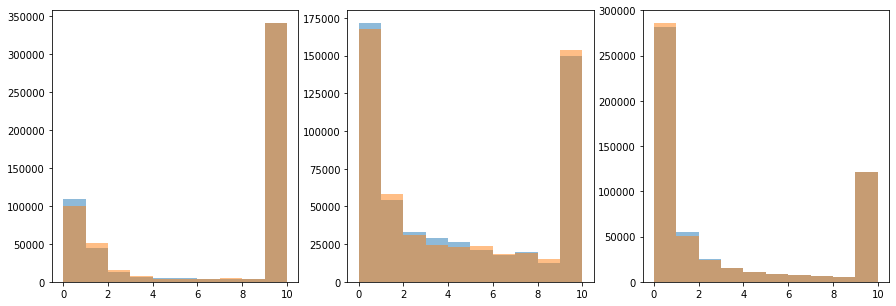

In [218]:
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.hist(np.clip(np.sum(all_counts[:, i, 0, 0, :], axis=1), None, 10), alpha=0.5, bins=np.arange(0, 11))
    plt.hist(np.clip(np.sum(all_counts[:, i, 0, 1, :], axis=1), None, 10), alpha=0.5, bins=np.arange(0, 11))
plt.show()

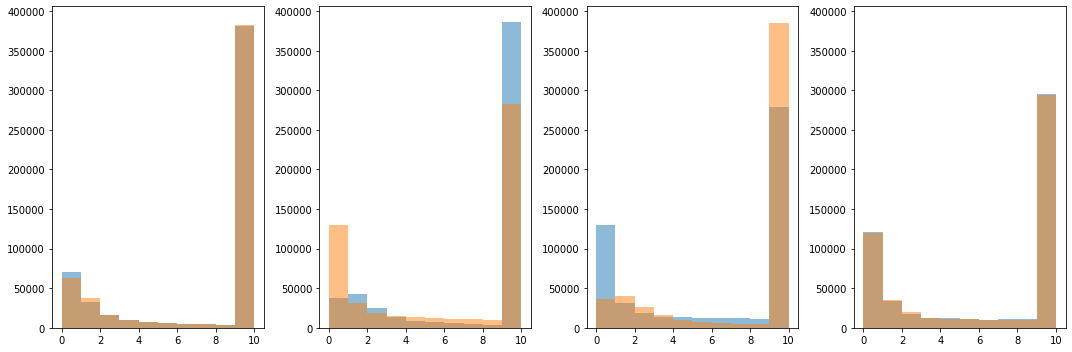

In [221]:
plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 4, 1)
plt.hist(np.clip(np.sum(all_counts[:, :, :, 0, 0], axis=(1, 2)), None, 10), alpha=0.5, bins=np.arange(0, 11))
plt.hist(np.clip(np.sum(all_counts[:, :, :, 1, 0], axis=(1, 2)), None, 10), alpha=0.5, bins=np.arange(0, 11))
plt.subplot(1, 4, 2, sharey=ax)
plt.hist(np.clip(np.sum(all_counts[:, :, :, 0, 1], axis=(1, 2)), None, 10), alpha=0.5, bins=np.arange(0, 11))
plt.hist(np.clip(np.sum(all_counts[:, :, :, 1, 1], axis=(1, 2)), None, 10), alpha=0.5, bins=np.arange(0, 11))
plt.subplot(1, 4, 3, sharey=ax)
plt.hist(np.clip(np.sum(all_counts[:, :, :, 0, 2], axis=(1, 2)), None, 10), alpha=0.5, bins=np.arange(0, 11))
plt.hist(np.clip(np.sum(all_counts[:, :, :, 1, 2], axis=(1, 2)), None, 10), alpha=0.5, bins=np.arange(0, 11))
plt.subplot(1, 4, 4, sharey=ax)
plt.hist(np.clip(np.sum(all_counts[:, :, :, 0, 3], axis=(1, 2)), None, 10), alpha=0.5, bins=np.arange(0, 11))
plt.hist(np.clip(np.sum(all_counts[:, :, :, 1, 3], axis=(1, 2)), None, 10), alpha=0.5, bins=np.arange(0, 11))

plt.tight_layout()
plt.show()

In [220]:
# interval, mat/pat, MM/FM/MF/FF
pvalues = np.ones((all_counts.shape[0], 2, 4))
for i in np.arange(len(all_positions)):
    for j in range(4):
        # mat
        pvalue = stats.binom_test(np.sum(all_counts[i, :, 0, :, j], axis=0), alternative='less')
        #if pvalue < 10**-10:
        #    print('mat M', all_chroms[i], all_positions[i], all_positions[i+1], pvalue, np.sum(all_counts[i, :, 0, :, 0], axis=0))
        pvalues[i, 0, j] = pvalue

        # pat
        pvalue = stats.binom_test(np.sum(all_counts[i, :, 1, :, j], axis=0), alternative='less')
        #if pvalue < 10**-10:
        #    print('pat M', all_chroms[i], all_positions[i], all_positions[i+1], pvalue)
        pvalues[i, 1, j] = pvalue
    

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.hist(np.clip(np.log10(pvalues[:, 0, 0]), -10, None), alpha=0.5, bins=np.arange(-10, 0.2, 0.2), log=True)
plt.hist(np.clip(np.log10(pvalues[:, 1, 0]), -10, None), alpha=0.5, bins=np.arange(-10, 0.2, 0.2), log=True)
plt.axvline(np.log10(0.05/pvalues.shape[0]))

plt.subplot(1, 4, 2)
plt.hist(np.clip(np.log10(pvalues[:, 0, 1]), -10, None), alpha=0.5, bins=np.arange(-10, 0.2, 0.2), log=True)
plt.hist(np.clip(np.log10(pvalues[:, 1, 1]), -10, None), alpha=0.5, bins=np.arange(-10, 0.2, 0.2), log=True)
plt.axvline(np.log10(0.05/pvalues.shape[0]))

plt.subplot(1, 4, 3)
plt.hist(np.clip(np.log10(pvalues[:, 0, 2]), -10, None), alpha=0.5, bins=np.arange(-10, 0.2, 0.2), log=True)
plt.hist(np.clip(np.log10(pvalues[:, 1, 2]), -10, None), alpha=0.5, bins=np.arange(-10, 0.2, 0.2), log=True)
plt.axvline(np.log10(0.05/pvalues.shape[0]))

plt.subplot(1, 4, 4)
plt.hist(np.clip(np.log10(pvalues[:, 0, 3]), -10, None), alpha=0.5, bins=np.arange(-10, 0.2, 0.2), log=True)
plt.hist(np.clip(np.log10(pvalues[:, 1, 3]), -10, None), alpha=0.5, bins=np.arange(-10, 0.2, 0.2), log=True)
plt.axvline(np.log10(0.05/pvalues.shape[0]))

plt.show()

In [ ]:
# try grouping regions

In [ ]:
# het_upd/iso_upd/del, MM/MF/FM/FF, nt/aut
del_to_count = defaultdict(lambda : np.zeros((3, 4, 2), dtype=int))
for chrom in [str(x) for x in range(1, 23)] + ['X']:
    print(chrom, end=' ')
    chrom_upds = [x for x in upds if x['chrom']==str(chrom)]
    chrom_dels = [x for x in deletions if x['chrom']==str(chrom)]
    
    for i, upd in enumerate(chrom_upds):
        has_match = False
        length = upd['end_pos'] - upd['start_pos']
        key = ('upd', chrom, upd['start_pos'], upd['end_pos'], i, upd['is_pat'])
        for upd2 in chrom_upds[i+1:]:
            if (upd['is_mat'] == upd2['is_mat']) and (min(upd['end_pos'], upd2['end_pos']) - max(upd['start_pos'], upd2['start_pos']) > 0.5*length):
                del_to_count[key][int(upd2['is_isodisomy']), 
                                  int(child_id_to_sex[upd2['child']]=='2') + 2*int(child_id_to_sex[child_to_sib[(upd2['family'], upd2['child'])]]=='2'),
                                  int(child_id_to_affected[upd2['child']]=='2')] += 1
                has_match = True
        for d in chrom_dels:
            if (upd['is_mat'] != d['is_mat']) and (min(upd['end_pos'], d['end_pos']) - max(upd['start_pos'], d['start_pos']) > 0.5*length):
                for child in d['trans']:
                    del_to_count[key][2, 
                                      int(child_id_to_sex[child]=='2') + 2*int(child_id_to_sex[child_to_sib[(d['family'], child)]]=='2'),
                                      int(child_id_to_affected[child]=='2')] += 1
                has_match = True
        if has_match:
            del_to_count[key][int(upd['is_isodisomy']), 
                              int(child_id_to_sex[upd['child']]=='2') + 2*int(child_id_to_sex[child_to_sib[(upd['family'], upd['child'])]]=='2'),
                              int(child_id_to_affected[upd['child']]=='2')] += 1


In [ ]:
keys = sorted(del_to_count.keys())
group_pvalues = np.ones((len(del_to_count), 4))
for i, key in enumerate(keys):
    counts = del_to_count[key]
    for j in range(4):
    
        pvalue = stats.binom_test(np.sum(counts[:, j, :], axis=0), alternative='less')
        #if pvalue < 0.05/len(group_pvalues):
        #   print(key, pvalue)
        #    print(counts)
        group_pvalues[i, j] = pvalue
    
    

In [ ]:
# MM/FM/MF/FF

plt.hist(np.clip(np.log10(group_pvalues[:, 0]), -8, None), alpha=0.5, bins=np.arange(-8, 0, 0.2), log=True, label='MM')
plt.hist(np.clip(np.log10(group_pvalues[:, 1]), -8, None), alpha=0.5, bins=np.arange(-8, 0, 0.2), log=True, label='FM')
plt.hist(np.clip(np.log10(group_pvalues[:, 2]), -8, None), alpha=0.5, bins=np.arange(-8, 0, 0.2), log=True, label='MF')
plt.hist(np.clip(np.log10(group_pvalues[:, 3]), -8, None), alpha=0.5, bins=np.arange(-8, 0, 0.2), log=True, label='FF')
plt.axvline(np.log10(0.05/group_pvalues.shape[0]))
plt.legend()
plt.show()